#**Фролов Владимир**
**Stepik User ID: 541150734**

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [ ]:
import os
import numpy as np
import pandas as pd
import random
from IPython.display import clear_output

from torch.autograd import Variable
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data_utils
from torch.utils.data import DataLoader


import skimage.io
from skimage.transform import resize
import pickle

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer

from time import time
from tqdm import tqdm
from tqdm import tqdm_notebook
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.2)
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

!pip install matplotlib --upgrade
print('matplotlib: {}'.format(matplotlib.__version__))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
matplotlib: 3.6.2


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
DATA_DIR = '/content/gdrive/MyDrive/autoencoders/'

In [ ]:
!pip freeze > requirements.txt

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

set_seed(0)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    DEVICE = torch.device("cpu")
else:
    print('CUDA is available!  Training on GPU ...')
    DEVICE = torch.device("cuda")

CUDA is available!  Training on GPU ...


In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values).astype('float32')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
# from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


Выведем таблицу атрибутов изображений

In [ ]:
attrs.head()

Male     Asian     White     Black      Baby     Child     Youth  \
0  1.568346 -1.889043  1.737203 -0.929729 -1.471799  -0.19558 -0.835609   
1  0.169851 -0.982408  0.422709 -1.282184  -1.36006 -0.867002 -0.452293   
2  0.997749 -1.364195 -0.157377 -0.756447 -1.891825 -0.871526 -0.862893   
3  1.122719 -1.997799  1.916144 -2.514214 -2.580071 -1.404239  0.057551   
4  1.078214 -2.008098  1.676211 -2.278056 -2.651845 -1.348408  0.649089   

  Middle Aged    Senior Black Hair  ... Pale Skin 5 o' Clock Shadow  \
0   -0.351468 -1.012533  -0.719593  ...  0.361738          1.166118   
1   -0.197521 -0.956073  -0.802107  ... -0.832036          -0.39768   
2    0.031445 -1.341523  -0.090037  ...  1.549743          1.884745   
3    0.000196 -1.273512  -1.431462  ...  0.567822         -0.176089   
4    0.017656 -1.889111  -1.857213  ... -1.461474         -0.955283   

  Strong Nose-Mouth Lines Wearing Lipstick Flushed Face High Cheekbones  \
0               -1.164916         -1.13999    -2.371746       -1.299932   
1                 0.87416        -0.945431    -0.268649       -0.006244   
2               -0.999765        -1.359858    -1.912108       -1.095634   
3                1.108125        -1.600944    -3.264613        0.813418   
4                0.119113        -1.128176    -3.161048         0.08268   

  Brown Eyes Wearing Earrings Wearing Necktie Wearing Necklace  
0  -0.414682        -1.144902        0.694007        -0.826609  
1  -0.030406        -0.480128         0.66676        -0.496559  
2   0.915126        -0.572332        0.144262        -0.841231  
3   0.308631        -0.848693        0.475941        -0.447025  
4  -0.439614        -0.359859       -0.760774        -0.410152  

[5 rows x 73 columns]


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9,
                                                                    shuffle=True,
                                                                    random_state=1)
train_loader = DataLoader(np.rollaxis(train_photos, 3, 1), batch_size=128, shuffle=True, worker_init_fn=seed_worker) # batch_size=128
val_loader = DataLoader(np.rollaxis(val_photos, 3, 1), batch_size=128) # batch_size=128

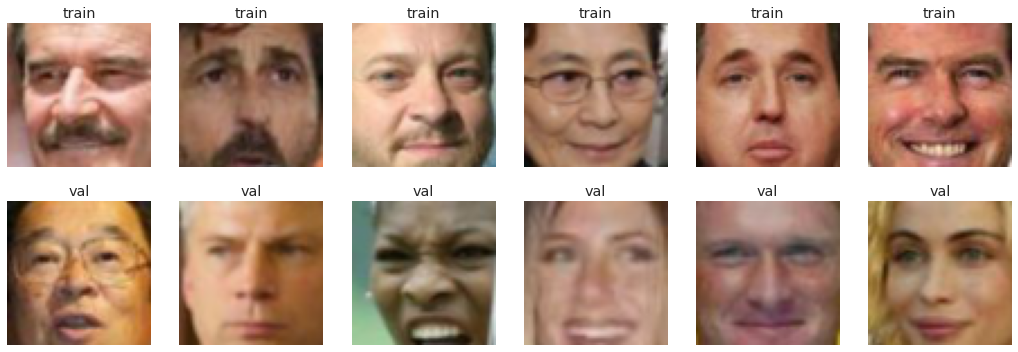

In [ ]:
x_train = next(iter(train_loader)).numpy()
x_val = next(iter(val_loader)).numpy()

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(np.rollaxis(x_train[i], 0, 3))
    plt.title('train')

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(np.rollaxis(x_val[i], 0, 3))
    plt.title('val')

plt.show();

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
torch.cuda.empty_cache()
!nvidia-smi

cuda
Mon Dec 19 07:50:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 128 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
      # <определите архитектуры encoder и decoder>
      super().__init__()

      self.encoder = nn.Sequential(
          # 1
          nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='replicate'),
          nn.ReLU(),
          # 2
          nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=2, dilation=2, padding=2, padding_mode='replicate'), # 64 -> 30
          nn.ReLU(),
          # 3
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='replicate'),
          nn.ReLU(),
          # 4
          nn.MaxPool2d(kernel_size=3, stride=2, padding=1), # 30 -> 15
          # 5
          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, padding_mode='replicate'),
          nn.ReLU(),
          # 6
          nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, stride=2, dilation=2), # 15 -> 4
          nn.ReLU(),

          nn.Flatten(),

          nn.Linear(in_features=4*4*256, out_features=4*256),
          nn.ReLU(),

          nn.Linear(in_features=4*256, out_features=dim_code)
      )

      self.decoder = nn.Sequential(
          nn.Linear(in_features=dim_code, out_features=4*256),
          nn.ReLU(),

          nn.Linear(in_features=4*256, out_features=4*4*256),
          nn.ReLU(),

          nn.Unflatten(1, torch.Size([256, 4, 4])),
          # 7
          nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=5, stride=2, dilation=2), # 4 -> 15
          nn.ReLU(),
          # 8
          nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          # 9
          nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True), # 15 -> 30
          # 10
          nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          # 11
          nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=5, stride=2, output_padding=1), # 30 -> 64
          nn.ReLU(),
          # 12
          nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1),
          nn.Sigmoid()
      )


    def forward(self, x):
      # <реализуйте forward проход автоэнкодера
      # в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code)
      # и полученная реконструкция изображения (reconstruction)>

      latent_code = self.encoder(x)
      reconstruction = self.decoder(latent_code)

      return reconstruction, latent_code

In [ ]:
import torchsummary
autoencoder = Autoencoder().to(DEVICE)
torchsummary.summary(autoencoder, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 30, 30]         102,464
              ReLU-4           [-1, 64, 30, 30]               0
            Conv2d-5          [-1, 128, 30, 30]          73,856
              ReLU-6          [-1, 128, 30, 30]               0
         MaxPool2d-7          [-1, 128, 15, 15]               0
            Conv2d-8          [-1, 256, 15, 15]         295,168
              ReLU-9          [-1, 256, 15, 15]               0
           Conv2d-10            [-1, 256, 4, 4]       1,638,656
             ReLU-11            [-1, 256, 4, 4]               0
          Flatten-12                 [-1, 4096]               0
           Linear-13                 [-1, 1024]       4,195,328
             ReLU-14                 [-

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

Обучение сети по эпохе

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
  model.train()
  running_loss = 0.0
  processed_size = 0

  for inputs in train_loader:
    inputs = inputs.to(DEVICE)

    reconstruct, latent = model(inputs)
    loss = criterion(reconstruct, inputs)

    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    processed_size += inputs.size(0)

    optimizer.zero_grad()

  train_loss = running_loss / processed_size

  return train_loss

Валидация сети по эпохе

In [ ]:
def eval_epoch(model, val_loader, criterion):
  model.eval()
  running_loss = 0.0
  processed_size = 0

  with torch.no_grad():
    for inputs in val_loader:
      inputs = inputs.to(DEVICE)

      reconstruct, latent = model(inputs)
      loss = criterion(reconstruct, inputs)
      running_loss += loss.item() * inputs.size(0)
      processed_size += inputs.size(0)

  val_loss = running_loss / processed_size

  return val_loss

Визуализация результатов

In [ ]:
def show_plot(x_val, x_reconstr, train_losses, val_losses):
  plt.figure(figsize=(15, 9))
  for k in range(5):
    plt.subplot(4, 5, k + 1)
    plt.imshow(np.rollaxis(x_val[k], 0, 3))
    plt.axis("off")
    plt.title('Input')

    plt.subplot(4, 5, k + 6)
    plt.imshow(np.rollaxis(x_reconstr[k], 0, 3))
    plt.axis("off")
    plt.title('Output')

  plt.subplot(2, 1, 2)
  plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label="train loss")
  plt.plot(np.arange(1, len(val_losses) + 1), val_losses, label="val loss")
  best_ep = np.argmin(val_losses) + 1
  plt.axvline(best_ep, color='r', label="best epoch")
  plt.legend(loc='upper right')
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.title(model_name + " loss")

  plt.tight_layout()
  plt.show();

Тренинг сети

In [ ]:
def train_model(train_loader, val_loader, model, model_name, epochs,
          criterion, optimizer, scheduler):
  X_val = next(iter(val_loader))
  best_loss = 7777
  since = time()
  dict_losses = {
      'train_loss': [],
      'val_loss': []
  }
  log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
  val_loss {v_loss:0.4f}"
  with tqdm(desc="epoch", total=epochs) as pbar_outer:

     for epoch in range(epochs):
       set_seed(0 + epoch)

       t_loss = fit_epoch(model, train_loader, criterion, optimizer)
       v_loss = eval_epoch(model, val_loader, criterion)

       scheduler.step()
       # save losses
       dict_losses['train_loss'].append(t_loss)
       dict_losses['val_loss'].append(v_loss)
       # save best model
       if best_loss > v_loss:
         best_loss = v_loss
         best_t_loss = t_loss
         torch.save(model.state_dict(), os.path.join(DATA_DIR, 'best_' + model_name + '.pth'))
         best_epoch = epoch + 1
         best_time = time() - since
       # save current model
       torch.save(model.state_dict(), os.path.join(DATA_DIR, 'last_' + model_name + '.pth'))
       # test
       model.eval()
       with torch.no_grad():
         x_reconst, latent = model(X_val.to(DEVICE))
         x_reconst = x_reconst.detach().cpu().numpy()
       # Visualize
       clear_output(wait=True)
       pbar_outer.update(1)
       tqdm.write(log_template.format(ep=epoch+1, t_loss=t_loss,\
                                      v_loss=v_loss))
       show_plot(X_val.numpy(), x_reconst, dict_losses['train_loss'], dict_losses['val_loss'])
  print(f'\nYEAH! Best time {best_time}, best epoch {best_epoch}, best train loss {best_t_loss}, best val loss {best_loss}')
  # load best weights
  model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_' + model_name + '.pth')))

  return model


Epoch 050 train_loss: 0.0034   val_loss 0.0053


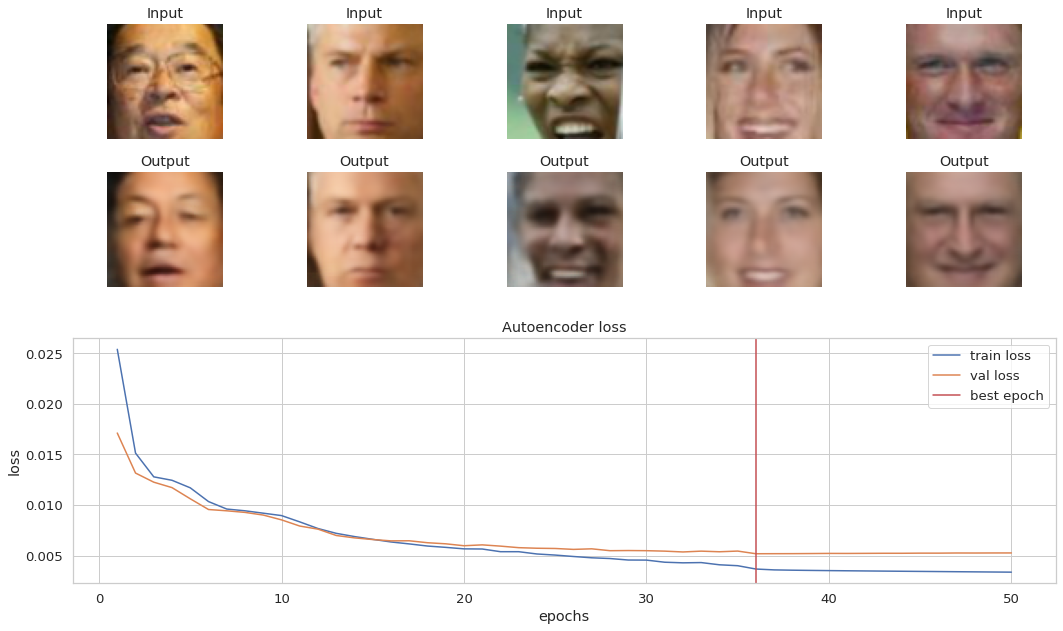


YEAH! Best time 3436.8128986358643, best epoch 36, best train loss 0.0036847897102765923, best val loss 0.005196010438590789


In [ ]:
torch.cuda.empty_cache()
criterion = F.mse_loss # args(input, targets)
autoencoder = Autoencoder().to(DEVICE)
optimizer = optim.AdamW(params = autoencoder.parameters())
scheduler = lr_scheduler.StepLR(optimizer, step_size=35, gamma=0.1)
model_name = 'Autoencoder'
epochs = 50
autoencoder = train_model(train_loader, val_loader, autoencoder, model_name, epochs, criterion, optimizer, scheduler)

Модель начала немного переобучаться с 36-й эпохи.

Загрузим обученный автоэнкодер:

In [ ]:
autoencoder = Autoencoder().to(DEVICE)
autoencoder.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_Autoencoder.pth')))

<All keys matched successfully>

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

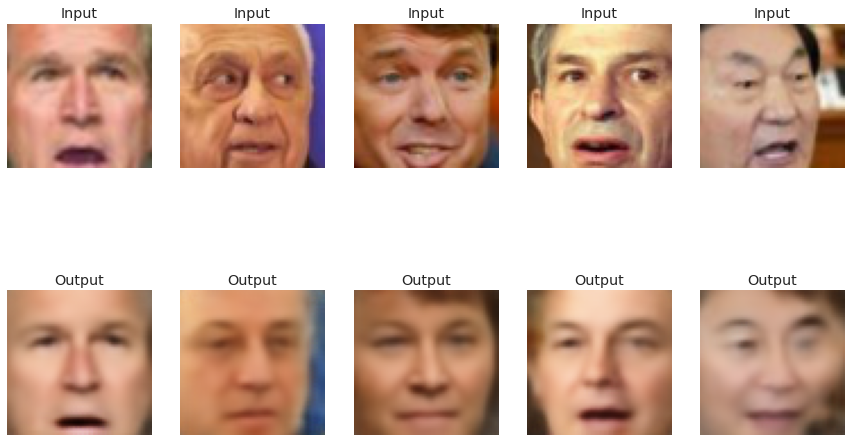

In [ ]:
x_val = next(iter(val_loader))
x_val_np = x_val.detach().numpy()

with torch.no_grad():
  x_reconstr, latent = autoencoder(x_val.to(DEVICE))
  x_reconstr = x_reconstr.cpu().numpy()

plt.figure(figsize=(15, 9))
for k in range(5):
  plt.subplot(2, 5, k + 1)
  plt.imshow(np.rollaxis(x_val_np[k + 6], 0, 3))
  plt.axis("off")
  plt.title('Input')

  plt.subplot(2, 5, k + 6)
  plt.imshow(np.rollaxis(x_reconstr[k + 6], 0, 3))
  plt.axis("off")
  plt.title('Output')

plt.show()

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

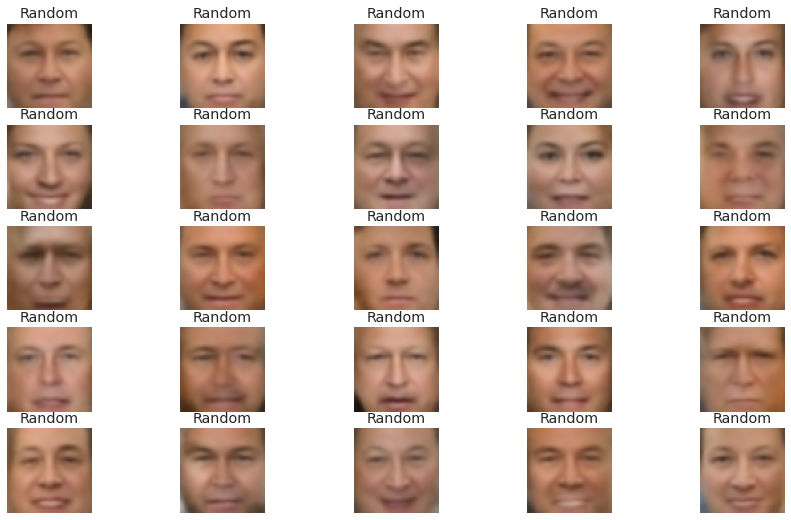

In [ ]:
# Возьмем батч (128 изображений)
train_batch = next(iter(val_loader))

# Получим 1 латент по нему
with torch.no_grad():
  train_latent = autoencoder.encoder(train_batch.to(DEVICE)).cpu()

# Рассчитаем стандартное отклонение и среднее по каждому элементу латента
latent_mu = train_latent.mean(0).unsqueeze(0)
latent_std = train_latent.std(0)

# Сгенерируем случайный тензор (25 х размер латентного вектора) из нормального распределения
eps = torch.randn(25, latent_std.shape[0])

# Приведем рандом к распределению латента
s = latent_mu + (eps * latent_std.unsqueeze(0))

# Реконструируем изображения
with torch.no_grad():
  output = autoencoder.decoder(s.to(DEVICE)).cpu().numpy()

# Визуализируем результаты
plt.figure(figsize=(15, 9))
for k in range(25):
  plt.subplot(5, 5, k + 1)
  plt.imshow(np.rollaxis(np.clip(output[k], 0, 1), 0, 3))
  plt.axis("off")
  plt.title('Random')

plt.show()

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

Загрузим обученный автоэнкодер:

In [ ]:
autoencoder = Autoencoder().to(DEVICE)
autoencoder.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_Autoencoder.pth')))

<All keys matched successfully>

Далее найдем индексы улыбающихся и не улыбающихся людей. Сформируем выборки по 20 штук:

In [ ]:
smile = attrs[attrs.Smiling > 1].head(20).index.to_list()
no_smile = attrs[attrs.Smiling < (-1.8)].head(20).index.to_list()

Выберем эти фото:

In [ ]:
smile_im = data[smile]
no_smile_im = data[no_smile]

Посмотрим на некоторые из них:

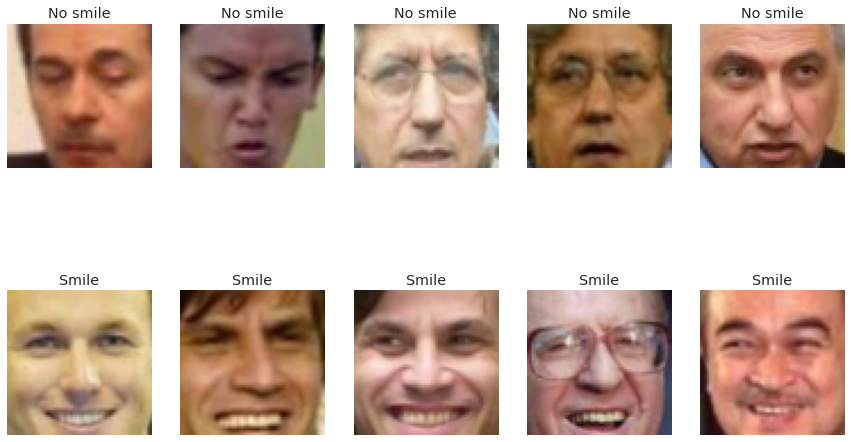

In [ ]:
plt.figure(figsize=(15, 9))
for k in range(5):
  plt.subplot(2, 5, k + 1)
  plt.imshow(no_smile_im[k])
  plt.axis("off")
  plt.title('No smile')

  plt.subplot(2, 5, k + 6)
  plt.imshow(smile_im[k])
  plt.axis("off")
  plt.title('Smile')

plt.show()

Далее передвинем оси и получим латенты улыбающихся и не улыбающихся людей:

In [ ]:
x = np.rollaxis(no_smile_im, 3, 1)
y = np.rollaxis(smile_im, 3, 1)

with torch.no_grad():
  latent_no_smile = autoencoder.encoder(torch.from_numpy(x).to(DEVICE)).cpu()
  latent_smile = autoencoder.encoder(torch.from_numpy(y).to(DEVICE)).cpu()

Осредним латенты:

In [ ]:
mean_latent_no_smile = latent_no_smile.mean(0)
mean_latent_smile = latent_smile.mean(0)

Исправим латенты не улыбающихся людей, получим реконструкции для обоих классов и визуализируем результаты:

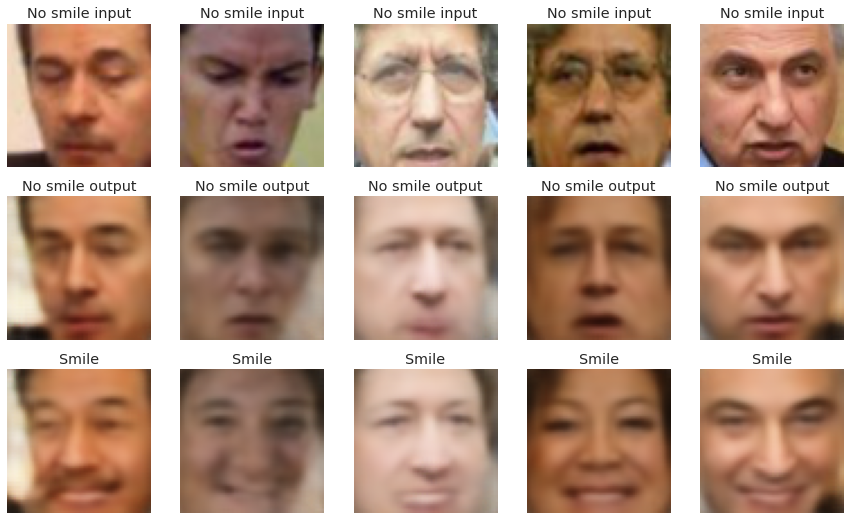

In [ ]:
smile_array = mean_latent_smile - mean_latent_no_smile
latent_to_smile = latent_no_smile + smile_array

with torch.no_grad():
  to_smile = autoencoder.decoder(latent_to_smile.to(DEVICE)).cpu().numpy()
  no_smile_reconstr = autoencoder.decoder(latent_no_smile.to(DEVICE)).cpu().numpy()

plt.figure(figsize=(15, 9))
for k in range(5):
  plt.subplot(3, 5, k + 1)
  plt.imshow(no_smile_im[k])
  plt.axis("off")
  plt.title('No smile input')

  plt.subplot(3, 5, k + 6)
  plt.imshow(np.rollaxis(no_smile_reconstr[k], 0, 3))
  plt.axis("off")
  plt.title('No smile output')

  plt.subplot(3, 5, k + 11)
  plt. imshow(np.rollaxis(to_smile[k], 0, 3))
  plt.axis("off")
  plt.title('Smile')

plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

Наденем на людей солнечные очки. По-сути, проделаем все то же, но для очков:

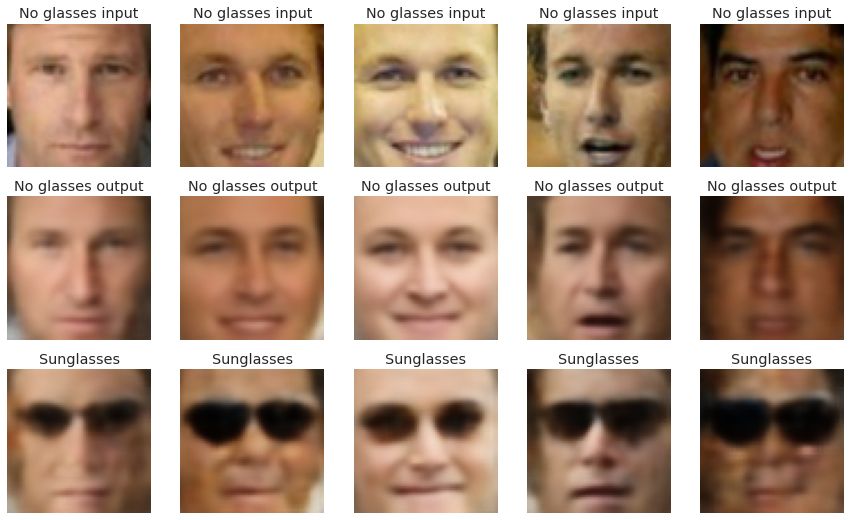

In [ ]:
no_glasses = attrs[attrs.Sunglasses < (-1.5)].head(20).index.to_list()
glasses = attrs[attrs.Sunglasses > 1.5].head(20).index.to_list()

no_glasses_im = data[no_glasses]
glasses_im = data[glasses]

x = np.rollaxis(no_glasses_im, 3, 1)
y = np.rollaxis(glasses_im, 3, 1)

with torch.no_grad():
  latent_no_glasses = autoencoder.encoder(torch.from_numpy(x).to(DEVICE)).cpu()
  latent_glasses = autoencoder.encoder(torch.from_numpy(y).to(DEVICE)).cpu()

mean_latent_no_glasses = latent_no_glasses.mean(0)
mean_latent_glasses = latent_glasses.mean(0)

glasses_array = mean_latent_glasses - mean_latent_no_glasses
latent_no_glasses_to_glasses = latent_no_glasses + glasses_array

with torch.no_grad():
  with_glasses = autoencoder.decoder(latent_no_glasses_to_glasses.to(DEVICE)).cpu().numpy()
  no_glasses = autoencoder.decoder(latent_no_glasses.to(DEVICE)).cpu().numpy()

plt.figure(figsize=(15, 9))
for k in range(5):
  plt.subplot(3, 5, k + 1)
  plt.imshow(no_glasses_im[k])
  plt.axis("off")
  plt.title('No glasses input')

  plt.subplot(3, 5, k + 6)
  plt.imshow(np.rollaxis(no_glasses[k], 0, 3))
  plt.axis("off")
  plt.title('No glasses output')

  plt.subplot(3, 5, k + 11)
  plt.imshow(np.rollaxis(with_glasses[k], 0, 3))
  plt.axis("off")
  plt.title('Sunglasses')

plt.show()

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [ ]:
print(f'Train size: {len(train_loader.dataset)} \nTest size: {len(test_loader.dataset)}')

Train size: 60000 
Test size: 10000


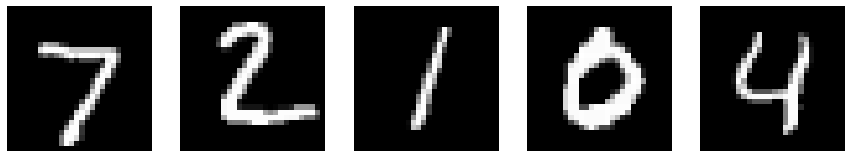

In [ ]:
x_testing = next(iter(test_loader))

plt.figure(figsize=(15, 4))
for k in range(5):
  plt.subplot(1, 5, k + 1)
  plt.imshow(x_testing[0][k].squeeze(0).numpy(), cmap='gray')
  plt.axis("off")

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
features = 8

class VAE(nn.Module):
    def __init__(self):
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста",
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super().__init__()

        self.encoder = nn.Sequential(
            # 1
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='replicate'),
            nn.ReLU(),
            # 2
            nn.MaxPool2d(kernel_size=4, stride=2, padding=1), # 28 -> 14
            # 3
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='replicate'),
            nn.ReLU(),
            # 4
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2), # 14 -> 6
            nn.ReLU(),

            nn.Flatten(),

            nn.Linear(in_features=6*6*64, out_features=4*64),
            nn.ReLU(),

            nn.Linear(in_features=4*64, out_features=features*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=features, out_features=4*64),
            nn.ReLU(),

            nn.Linear(in_features=4*64, out_features=6*6*64),
            nn.ReLU(),

            nn.Unflatten(1, torch.Size([64, 6, 6])),
            # 5
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2), # 6 -> 14
            nn.ReLU(),
            # 6
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # 7
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True), # 14 -> 28
            # 8
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1),
        )

    def encode(self, x):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu и logsigma>
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]

        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
      if self.training:
        # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
        std = torch.exp(0.5 * logsigma)
        eps = torch.randn_like(std)
        sample = mu + (eps * std)
      else:
        # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
        # на инференсе выход автоэнкодера должен быть детерминирован.
        sample = mu
      return sample

    def decode(self, z, eps=1e-7):
        # <реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction>
        x = self.decoder(z)
        reconstruction = torch.clamp(x.sigmoid(), min=eps, max=1-eps)

        return reconstruction

    def forward(self, x):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

In [ ]:
import torchsummary
vae = VAE().to(DEVICE)
torchsummary.summary(vae, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          36,928
              ReLU-5           [-1, 64, 14, 14]               0
            Conv2d-6             [-1, 64, 6, 6]          65,600
              ReLU-7             [-1, 64, 6, 6]               0
           Flatten-8                 [-1, 2304]               0
            Linear-9                  [-1, 256]         590,080
             ReLU-10                  [-1, 256]               0
           Linear-11                   [-1, 16]           4,112
           Linear-12                  [-1, 256]           2,304
             ReLU-13                  [-1, 256]               0
           Linear-14                 [-

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())

    return loss / mu.shape[0]

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    batch = x.shape[0]
    x = x.view(-1)
    reconstruction = reconstruction.view(-1)

    loss = nn.BCELoss(reduction='sum')

    return loss(reconstruction, x) / batch

def loss_vae(x, mu, logsigma, reconstruction):

    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

Исходя из специфики VAE (он учит параметры нормального распределния), нужно заново написать все функции обучения.

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    processed_size = 0

    for inputs, _ in train_loader:
        inputs = inputs.to(DEVICE)

        mu, logsigma, reconstruction  = model(inputs)
        loss = criterion(inputs, mu, logsigma, reconstruction)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)

        optimizer.zero_grad()

    train_loss = running_loss / processed_size

    return train_loss

In [ ]:
def eval_epoch(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    processed_size = 0

    with torch.no_grad():

      for inputs, _ in test_loader:
          inputs = inputs.to(DEVICE)

          mu, logsigma, reconstruction  = model(inputs)
          loss = criterion(inputs, mu, logsigma, reconstruction)

          running_loss += loss.item() * inputs.size(0)
          processed_size += inputs.size(0)

    test_loss = running_loss / processed_size

    return test_loss

In [ ]:
def show_plot(x_test, x_reconstr, train_losses, test_losses):
  plt.figure(figsize=(15, 9))
  for k in range(5):
    plt.subplot(4, 5, k + 1)
    plt.imshow(x_test[k], cmap='gray')
    plt.axis("off")
    plt.title('Input')

    plt.subplot(4, 5, k + 6)
    plt.imshow(x_reconstr[k], cmap='gray')
    plt.axis("off")
    plt.title('Output')

  plt.subplot(2, 1, 2)
  plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label="train loss")
  plt.plot(np.arange(1, len(test_losses) + 1), test_losses, label="test loss")
  best_ep = np.argmin(test_losses) + 1
  plt.axvline(best_ep, color='r', label="best epoch")
  plt.legend(loc='upper right')
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.title(model_name + " loss")

  plt.tight_layout()
  plt.show();

In [ ]:
def train_model(train_loader, test_loader, model, model_name, epochs,
          criterion, optimizer):
  X_test, _ = next(iter(test_loader))
  best_loss = 77777
  since = time()
  dict_losses = {
      'train_loss': [],
      'test_loss': []
  }
  log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
  test_loss {v_loss:0.4f}"
  with tqdm(desc="epoch", total=epochs) as pbar_outer:

     for epoch in range(epochs):
       set_seed(0 + epoch)

       train_loss = fit_epoch(model, train_loader, criterion, optimizer)
       test_loss = eval_epoch(model, test_loader, criterion)

       # save losses
       dict_losses['train_loss'].append(train_loss)
       dict_losses['test_loss'].append(test_loss)
       # save best model
       if best_loss > test_loss:
         best_loss = test_loss
         best_t_loss = train_loss
         torch.save(model.state_dict(), os.path.join(DATA_DIR, 'best_' + model_name + '.pth'))
         best_epoch = epoch + 1
         best_time = time() - since
       # save current model
       torch.save(model.state_dict(), os.path.join(DATA_DIR, 'last_' + model_name + '.pth'))
       # test
       model.eval()
       with torch.no_grad():
         mu, logsigma, reconstruction = model(X_test.to(DEVICE))
         x_reconst = reconstruction.detach().cpu().squeeze(1).numpy()
       # Visualize
       clear_output(wait=True)
       pbar_outer.update(1)
       tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                      v_loss=test_loss))
       show_plot(X_test.squeeze(1).numpy(), x_reconst, dict_losses['train_loss'], dict_losses['test_loss'])
  print(f'\nYEAH! Best time {best_time}, best epoch {best_epoch}, best train loss {best_t_loss}, best test loss {best_loss}')
  # load best weights
  model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_' + model_name + '.pth')))

  return model


Epoch 050 train_loss: 97.8337   test_loss 96.7126


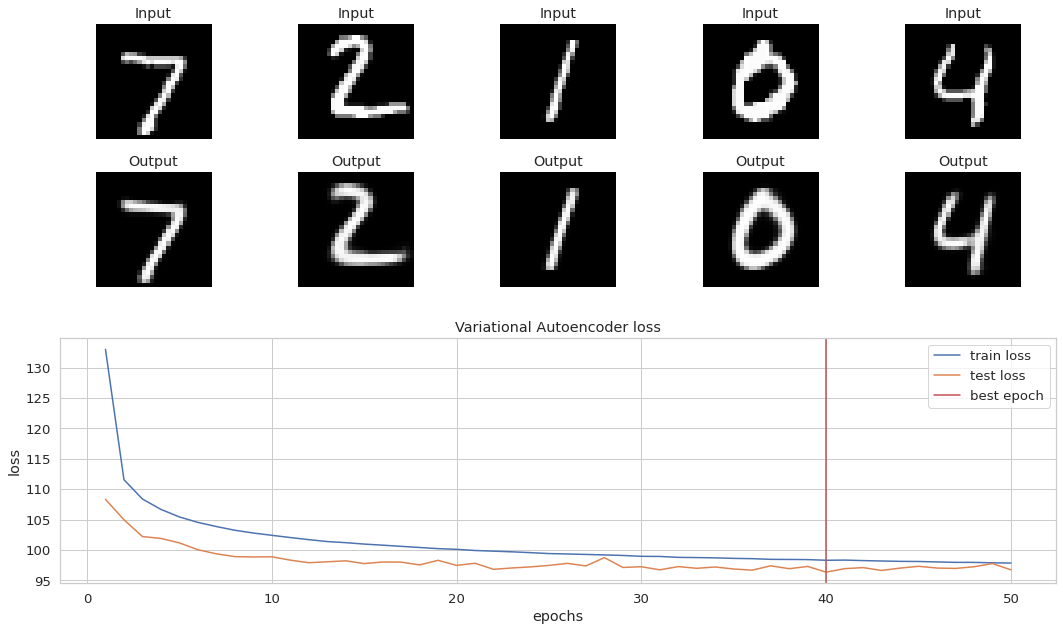


YEAH! Best time 854.938111782074, best epoch 40, best train loss 98.29185889485677, best test loss 96.33343304443359


In [ ]:
torch.cuda.empty_cache()
criterion = loss_vae
vae = VAE().to(DEVICE)
optimizer = optim.AdamW(params = vae.parameters())
epochs = 50
model_name = 'Variational Autoencoder'
vae = train_model(train_loader, test_loader, vae, model_name, epochs, criterion, optimizer)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

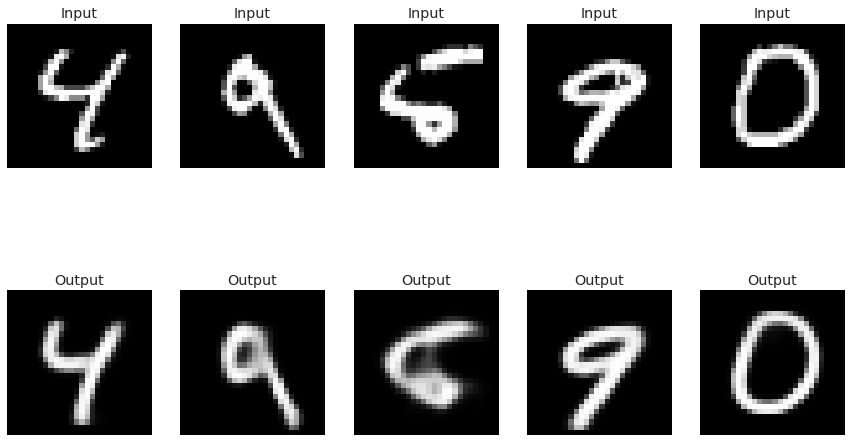

In [ ]:
x_test, labels = next(iter(test_loader))
x_test_np = x_test.detach().squeeze(1).numpy()

with torch.no_grad():
  vae.eval()
  mu, logsigma, x_reconstr = vae(x_test.to(DEVICE))
  x_reconstr = x_reconstr.cpu().squeeze(1).numpy()

plt.figure(figsize=(15, 9))
for k in range(5):
  plt.subplot(2, 5, k + 1)
  plt.imshow(x_test_np[k + 6], cmap='gray')
  plt.axis("off")
  plt.title('Input')

  plt.subplot(2, 5, k + 6)
  plt.imshow(x_reconstr[k + 6], cmap='gray')
  plt.axis("off")
  plt.title('Output')

plt.show()

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
vae = VAE().to(DEVICE)
vae.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_Variational Autoencoder.pth')))

<All keys matched successfully>

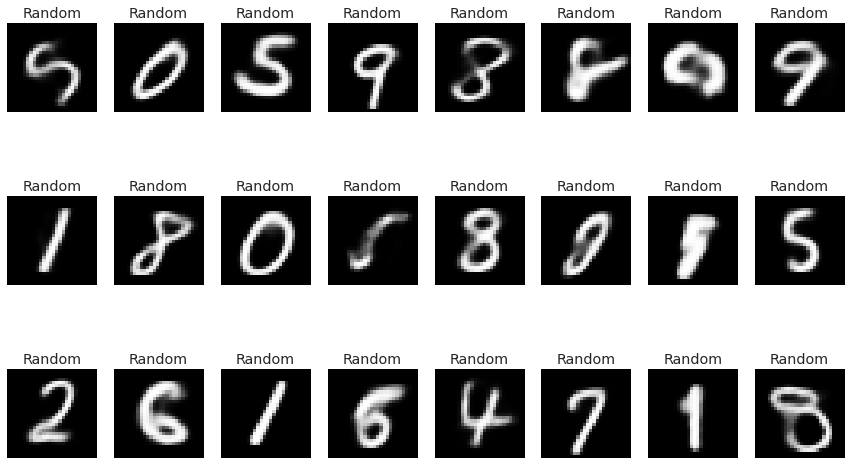

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, features) for i in range(24)])
z = torch.FloatTensor(z).to(DEVICE)
with torch.no_grad():
  output = vae.decode(z).cpu().squeeze(1).numpy()

plt.figure(figsize=(15, 9))
for k in range(24):
  plt.subplot(3, 8, k + 1)
  plt.imshow(output[k], cmap='gray')
  plt.axis("off")
  plt.title('Random')

plt.show()

Или:

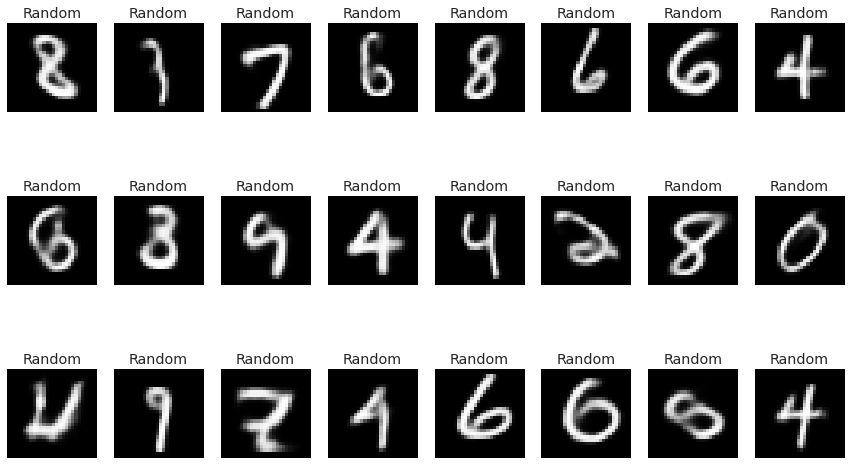

In [ ]:
train_batch, _ = next(iter(test_loader))

# Получим латенты по батчу
with torch.no_grad():
  vae.eval()
  mu, _ = vae.encode(train_batch.to(DEVICE))

# Рассчитаем среднее по каждому элементу латента
latent_mu = mu.cpu().mean(0)

# Сгенерируем случайный тензор (25 х размер латентного вектора) из нормального распределения
eps = torch.randn(24, latent_mu.shape[-1])

# Приведем рандом к распределению латента
s = latent_mu + eps

# Реконструируем изображения
with torch.no_grad():
  output = vae.decode(s.to(DEVICE)).cpu().squeeze(1).numpy()

# Визуализируем результаты
plt.figure(figsize=(15, 9))
for k in range(24):
  plt.subplot(3, 8, k + 1)
  plt.imshow(output[k], cmap='gray')
  plt.axis("off")
  plt.title('Random')

plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
vae = VAE().to(DEVICE)
vae.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_Variational Autoencoder.pth')))

<All keys matched successfully>

Получим латентные представления цифр тестового датасета:

In [ ]:
labels = np.zeros(1)
latents = np.zeros((1,8))

with torch.no_grad():
  vae.eval()
  for inputs, label in test_loader:
    inputs = inputs.to(DEVICE)
    latent, _ = vae.encode(inputs)
    latents = np.concatenate((latents, latent.cpu().numpy()))
    labels = np.concatenate((labels, label.numpy()))

labels = np.delete(labels, 0, axis=0)
latents = np.delete(latents, 0, axis=0)

print(f'Размеры полученных латентных векторов {latents.shape}. \nРазмеры полученных лейблов латентных векторов {labels.shape}.')

Размеры полученных латентных векторов (10000, 8). 
Размеры полученных лейблов латентных векторов (10000,).


Запишем все в файл:

In [ ]:
dict_latent_vae1 = {
    'latents': latents,
    'labels': labels}

with open(os.path.join(DATA_DIR, 'dict_latent_VAE.pickle'), 'wb') as f:
        pickle.dump(dict_latent_vae1, f)

Загрузим:

In [ ]:
with open(os.path.join(DATA_DIR, 'dict_latent_VAE.pickle'), 'rb') as f:
        dict_latent_vae1 = pickle.load(f)

Сожмем латентные векторы до размерности 2:

In [ ]:
latents = dict_latent_vae1['latents']

latents_tsne = TSNE(n_components=2, random_state=1).fit_transform(latents)
latents_tsne.shape

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(10000, 2)

In [ ]:
dict_latent_vae1['latents_tsne'] = latents_tsne
with open(os.path.join(DATA_DIR, 'dict_latent_Variational Autoencoder.pickle'), 'wb') as f:
    pickle.dump(dict_latent_vae1, f)

In [ ]:
with open(os.path.join(DATA_DIR, 'dict_latent_Variational Autoencoder.pickle'), 'rb') as f:
        dict_latent_vae1 = pickle.load(f)

latents = dict_latent_vae1['latents']
labels = dict_latent_vae1['labels']
latents_tsne = dict_latent_vae1['latents_tsne']

Визуализируем результаты:

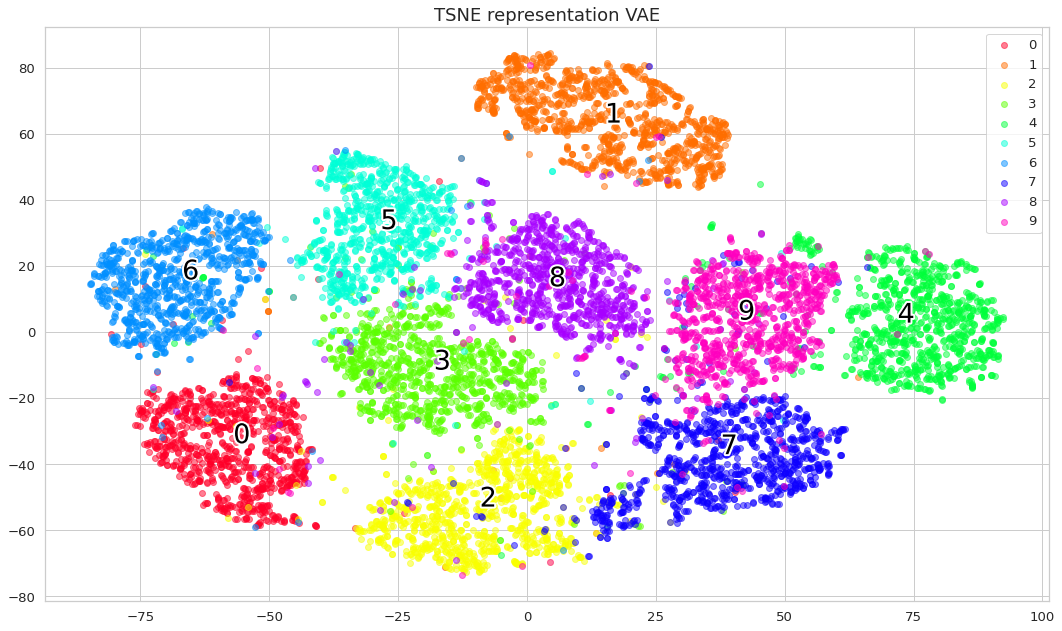

In [ ]:
from matplotlib import patheffects as path_effects

colors = cm.gist_rainbow(np.linspace(0, 1, len(np.unique(labels))))

plt.figure(figsize=(15, 9))
for label, color in zip(np.unique(labels), colors):
    plt.scatter(latents_tsne[labels== label, 0],
                latents_tsne[labels== label, 1],
                c=color.reshape(1,-1),
                alpha=0.5,
                label=str(int(label))
                )
    x = np.mean(latents_tsne[labels== label, 0])
    y = np.mean(latents_tsne[labels== label, 1])
    plt.text(x, y, str(int(label)),
             fontsize=27,
             c='black',
             path_effects=[
                           path_effects.Stroke(linewidth=4, foreground='white'),
                           path_effects.Normal()
                           ],
             )

plt.title('TSNE representation VAE', fontsize=18)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Что вы думаете о виде латентного представления?

Представление не совсем компактно, однако точки расположены в кластерах, принадлежащих одной цифре, и визуально разделимы. Кластеры визуально схожих цифр так же расположены близко друг к другу. Модель сгруппировала каждый из классов, сгенерировав каждый латентный вектор из произвольного нормального распределения, благодаря чему передвигаться по скрытому пространству и генерить новые данные станет проще, по крайней мере мы можем делать это более эффективно.

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
num_classes = 10
features = 8

class CVAE(nn.Module):
    def __init__(self):
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста",
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super().__init__()

        self.flatten = nn.Flatten()

        self.encoder = nn.Sequential(
            nn.Linear(in_features=(28*28+num_classes), out_features=4*64),
            nn.ReLU(),

            nn.Linear(in_features=4*64, out_features=64),
            nn.ReLU(),

            nn.Linear(in_features=64, out_features=features*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=(features+num_classes), out_features=64),
            nn.ReLU(),

            nn.Linear(in_features=64, out_features=4*64),
            nn.ReLU(),

            nn.Linear(in_features=4*64, out_features=28*28)
        )

        self.ohe = LabelBinarizer()

    def onehot(self, label, num_classes=num_classes):
      # обучаем кодировщик
      # label = label.int() for torchsummary
      lb_classes = self.ohe.fit_transform(np.arange(num_classes).reshape(-1,1))
      lb_class = torch.FloatTensor(lb_classes[label.cpu()]).to(DEVICE)

      return lb_class

    def encode(self, x, label):
        '''
        <реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и класс картинки>
        '''
        # Первым слоем в энкодере идет свертка.
        # Сделаем так, чтобы изображение просто увеличилось на 1 строку пикселей.
        # Для этого получим закодированный вектор классов,
        # "приклеим" к нему недостающее количество, и все это "приклеим" к картинке.

        lb_class = self.onehot(label)

        x = self.flatten(x)
        x = torch.cat((x, lb_class), dim=-1)

        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]

        return mu, logsigma, label

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            '''<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>'''
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)

        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            sample = mu

        return sample

    def decode(self, z, label, eps=1e-7):
        '''
        <реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction>
        '''
        lb_class = self.onehot(label)
        z = torch.cat((z, lb_class), dim=1)
        z = self.decoder(z)

        reconstruction = torch.clamp(z.sigmoid(), min=eps, max=1-eps).view(-1, 1, 28, 28)

        return reconstruction

    def get_latent(self, x, label):
        lb_class = self.onehot(label)
        x = self.flatten(x)
        x = torch.cat((x, lb_class), dim=-1)
        x = self.encoder(x).view(-1, 2, features)

        mu = x[:, 0, :]
        log_var = x[:, 1, :]
        # get the latent vector through reparameterization
        z = self.gaussian_sampler(mu, log_var)
        return z

    def forward(self, x, label):
        '''
        <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        '''
        mu, logsigma, label = self.encode(x, label)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, label).view(-1, 1, 28, 28)

        return mu, logsigma, reconstruction

В качестве функции потерь будем использовать ту же, что и для VAE (кросс-энтропия + KL-дивергенция)

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных классов
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())

    return loss / mu.shape[0]

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    batch = x.shape[0]
    x = x.view(-1)
    reconstruction = reconstruction.view(-1)

    loss = nn.BCELoss(reduction='sum')

    return loss(reconstruction, x) / batch

def loss_cvae(x, mu, logsigma, reconstruction):

   return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

Напишем функцию обучения:

In [ ]:
def train_model(train_loader, test_loader, model, model_name, epochs, criterion, optimizer):
    X, L = next(iter(test_loader))

    best_loss = 77777
    since = time()

    # loss per batch
    train_losses = []
    test_losses = []

    for epoch in tqdm(range(epochs)):
        set_seed(0 + epoch)
        # train
        model.train()
        train_losses_per_epoch = []

        for x_batch, label in train_loader:
          mu, logsigma, reconstruction = model(x_batch.to(DEVICE), label.to(DEVICE))
          loss = criterion(x_batch.to(DEVICE), mu, logsigma, reconstruction)

          loss.backward()
          optimizer.step()

          train_losses_per_epoch.append(loss.detach().cpu().item())

          optimizer.zero_grad()

        train_losses.append(np.mean(train_losses_per_epoch))
        # test
        model.eval()
        test_losses_per_epoch = []

        with torch.no_grad():
          for x_batch, label in test_loader:
            x_batch = x_batch.to(DEVICE)
            label = label.to(DEVICE)
            mu, logsigma, reconstruction = model(x_batch, label)
            loss = criterion(x_batch, mu, logsigma, reconstruction)

            test_losses_per_epoch.append(loss.detach().cpu().item())

        test_losses.append(np.mean(test_losses_per_epoch))
        # save best model
        if best_loss > test_losses[-1]:
            best_loss = test_losses[-1]
            best_t_loss = train_losses[-1]
            torch.save(model.state_dict(), os.path.join(DATA_DIR, 'best_' + model_name + '.pth'))
            best_epoch = epoch + 1
            best_time = time() - since
        # save current model
        torch.save(model.state_dict(), os.path.join(DATA_DIR, 'last_' + model_name + '.pth'))
        # Visualize
        clear_output(wait=True)

        plt.figure(figsize=(15, 9))

        for k in range(5):
            plt.subplot(4, 5, k + 1)
            plt.imshow(x_batch.cpu().squeeze(1).numpy()[k], cmap='gray')
            plt.axis("off")
            plt.title('Input')

            plt.subplot(4, 5, k + 6)
            plt.imshow(reconstruction.cpu().squeeze(1).numpy()[k], cmap='gray')
            plt.axis("off")
            plt.title('Output')

        plt.subplot(2,1,2)
        plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label="train loss")
        plt.plot(np.arange(1, len(test_losses) + 1), test_losses, label="test loss")
        best_ep = np.argmin(test_losses) + 1
        plt.axvline(best_ep, color='r', label="best epoch")
        plt.legend(loc='upper right')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.title(model_name + " loss")

        plt.suptitle(f'{epoch + 1} / {epochs} - train loss: {train_losses[-1]:.4f} - test loss: {test_losses[-1]:.4f}',
                     fontsize=18)

        plt.show();

    print(f'\nYEAH! Best time {best_time}, best epoch {best_epoch}, best test loss {best_loss}, best train loss {best_t_loss}')
    # load best weights
    model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_' + model_name + '.pth')))

    return model

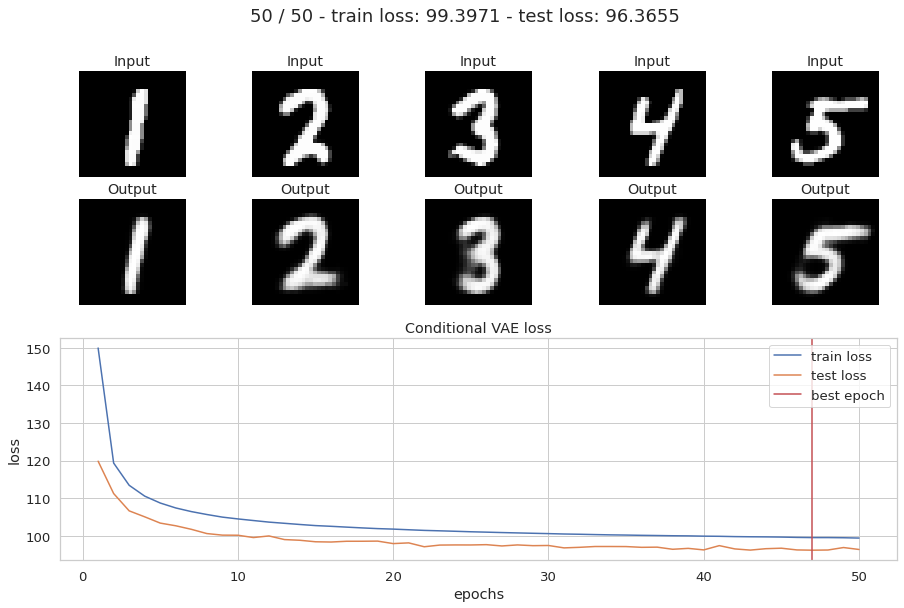


YEAH! Best time 845.4855375289917, best epoch 47, best test loss 96.17457836504562, best train loss 99.52271051432291


In [ ]:
torch.cuda.empty_cache()
cvae = CVAE().to(DEVICE)
criterion = loss_cvae
optimizer = optim.AdamW(params = cvae.parameters())
model_name = 'Conditional VAE'
epochs = 50
cvae = train_model(train_loader, test_loader, cvae, model_name, epochs, criterion, optimizer)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

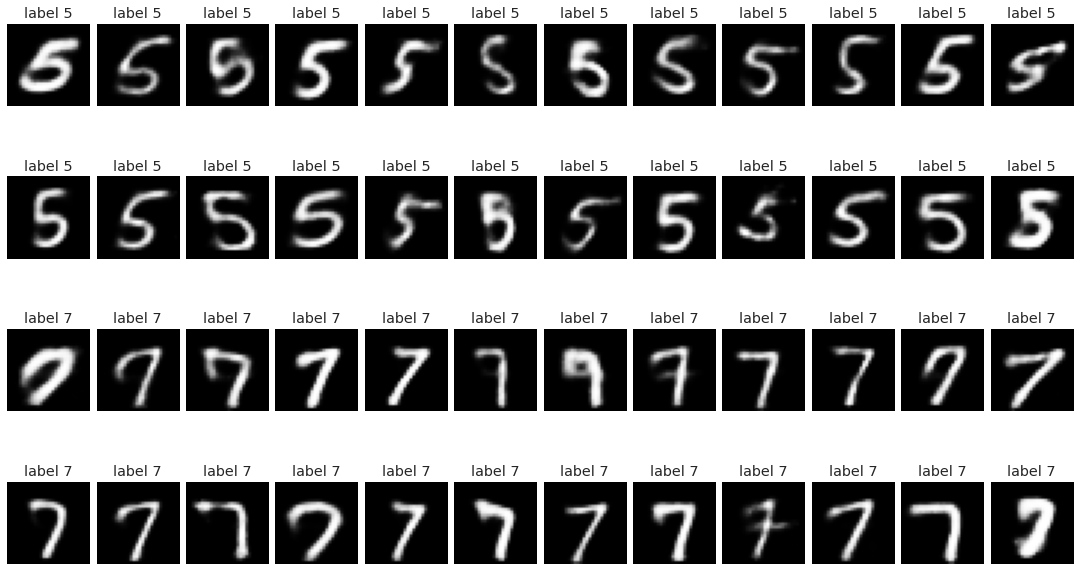

In [ ]:
z = np.array([np.random.normal(0, 1, features) for i in range(24)]).reshape(-1, features)
z = torch.FloatTensor(z).to(DEVICE)

label_5 = np.array([5 for i in range(24)])
label_5 = torch.Tensor(label_5).int().to(DEVICE)
label_7 = np.array([7 for i in range(24)])
label_7 = torch.Tensor(label_7).int().to(DEVICE)

with torch.no_grad():
  output_5 = cvae.decode(z, label_5).cpu().squeeze(1).numpy()
  output_7 = cvae.decode(z, label_7).cpu().squeeze(1).numpy()

plt.figure(figsize=(15, 9))
for k in range(24):
    plt.subplot(4, 12, k + 1)
    plt.axis("off")
    plt.imshow(output_5[k], cmap='gray')
    plt.title('label 5')

    plt.subplot(4, 12, k + 25)
    plt.axis("off")
    plt.imshow(output_7[k], cmap='gray')
    plt.title('label 7')

plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)
plt.show();

Сделаем матрицу 10 х 10:

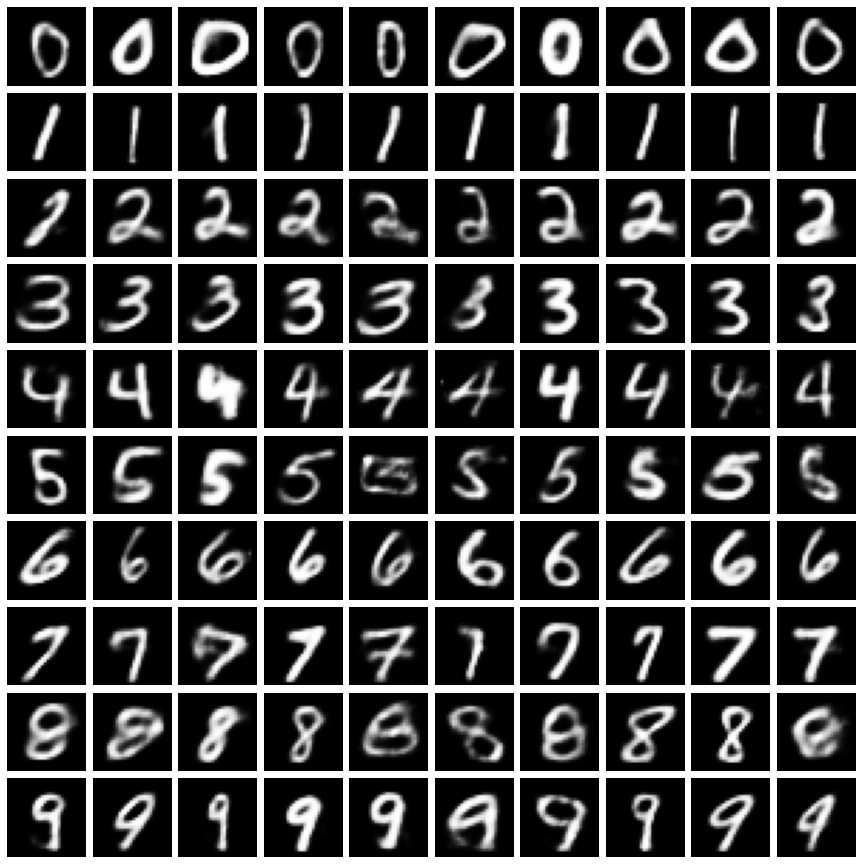

In [ ]:
# 100 векторов из нормального распределения
z = np.array([np.random.normal(0, 1, features) for i in range(100)]).reshape(-1, features)
z = torch.FloatTensor(z).to(DEVICE)
# метки от 0 до 9 (каждая записана по 10 раз)
labels = np.array([j for j in range(10) for i in range(10)])
labels = torch.Tensor(labels).int().to(DEVICE)
# 100 предсказаний
with torch.no_grad():
  output = cvae.decode(z, labels).cpu().squeeze(1).numpy()

plt.figure(figsize=(12, 12))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.axis("off")
    plt.imshow(output[i], cmap='gray')

plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)
plt.show();

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
cvae = CVAE().to(DEVICE)
cvae.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_Conditional VAE.pth')))

<All keys matched successfully>

Получим латенты и их представление цифр тестового датасета, запишем латентные векторы и их лейблы:

In [ ]:
labels = np.zeros(1)
latents = np.zeros((1,8))

with torch.no_grad():
  cvae.eval()
  for inputs, label in test_loader:
    inputs = inputs.to(DEVICE)
    latent = cvae.get_latent(inputs, label.to(DEVICE))
    latents = np.concatenate((latents, latent.cpu().numpy()))
    labels = np.concatenate((labels, label.numpy()))

labels = np.delete(labels, 0, axis=0)
latents = np.delete(latents, 0, axis=0)

dict_latent_cvae1 = {
    'latents': latents,
    'labels': labels}

with open(os.path.join(DATA_DIR, 'dict_latent_Conditional VAE.pickle'), 'wb') as f:
    pickle.dump(dict_latent_cvae1, f)

print(f'Размеры полученных латентных векторов {latents.shape}. \nРазмеры полученных лейблов латентных векторов {labels.shape}.')

Размеры полученных латентных векторов (10000, 8). 
Размеры полученных лейблов латентных векторов (10000,).


Загрузим и сожмем латентные векторы, а их представления запишем:

In [ ]:
with open(os.path.join(DATA_DIR, 'dict_latent_Conditional VAE.pickle'), 'rb') as f:
        dict_latent_cvae1 = pickle.load(f)

latents = dict_latent_cvae1['latents']
latents_tsne = TSNE(n_components=2, random_state=1).fit_transform(latents)

dict_latent_cvae1['latents_tsne'] = latents_tsne
with open(os.path.join(DATA_DIR, 'dict_latent_Conditional VAE.pickle'), 'wb') as f:
    pickle.dump(dict_latent_cvae1, f)

print('Размеры сжатых латентных векторов', latents_tsne.shape)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Размеры сжатых латентных векторов (10000, 2)


Визуализируем результаты:

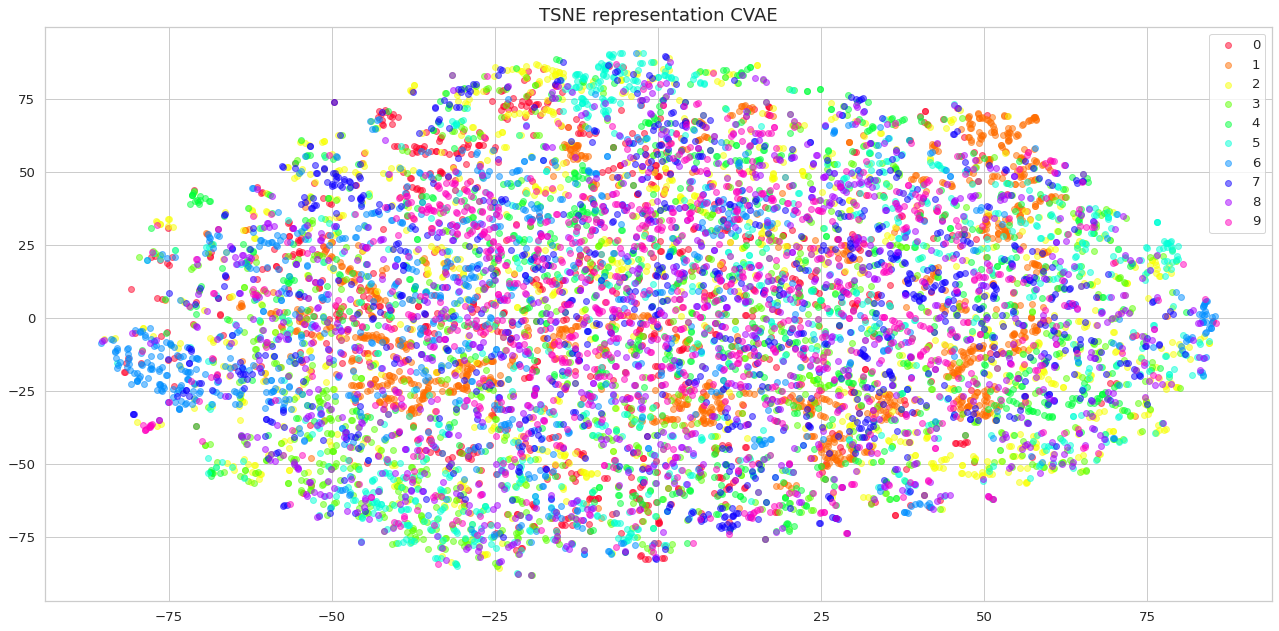

In [ ]:
with open(os.path.join(DATA_DIR, 'dict_latent_Conditional VAE.pickle'), 'rb') as f:
        dict_latent_cvae1 = pickle.load(f)

latents = dict_latent_cvae1['latents']
labels = dict_latent_cvae1['labels']
latents_tsne = dict_latent_cvae1['latents_tsne']

colors = cm.gist_rainbow(np.linspace(0, 1, len(np.unique(labels))))

plt.figure(figsize=(18, 9))
for label, color in zip(np.unique(labels), colors):
    plt.scatter(latents_tsne[labels== label, 0],
                latents_tsne[labels== label, 1],
                c=color.reshape(1,-1),
                alpha=0.5,
                label=str(int(label))
                )

plt.title('TSNE representation CVAE', fontsize=18)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

В отличие от предыдущей, на данной картине классы не сгруппированы и никаких кластеров отдельных классов здесь проследить не удается, все классы находятся в едином облаке. Чтобы сгенерировать изображение нужно учитывать принадлежность пространства признаков определенному классу, т.к. пространство признаков разных классов смешано. Однако в итоге CVAE способен воспроизвести различные классы, используя один и тот же латентный вектор, что несомненно упрощает генерацию, а также делает ее немного более качественной, в отличие от VAE.

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
# noise_factor = 0.5
# X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

Загрузим данные и для тренировки возьмем 5к картинок

In [ ]:
data, attrs = fetch_dataset()

data = data[:5000]
# запишем данные в файл, чтобы не повторять код загрузки полного датасета
with open(os.path.join(DATA_DIR, 'data_fetch_5000.pickle'), 'wb') as f:
    pickle.dump(data, f)

Загрузим данные из файла:

In [ ]:
with open(os.path.join(DATA_DIR, 'data_fetch_5000.pickle'), 'rb') as f:
        data = pickle.load(f)

data.shape

(5000, 64, 64, 3)

Наложим шум на изображения и засплитим выборку:

In [ ]:
noisy_data = np.copy(data) + 0.3 * np.random.normal(loc=0.0, scale=1.0, size=data.shape).astype('float32')

X_train, X_val, Y_train, Y_val = train_test_split(noisy_data, data,train_size=0.8,
                                                  shuffle=True, random_state=1
                                                  )

# сделаем dataloaders (передвинем каналы в начало)
train_loader = DataLoader(list(zip(np.rollaxis(X_train, 3, 1), np.rollaxis(Y_train, 3, 1))),
                          batch_size=64, shuffle=True
                          )
val_loader = DataLoader(list(zip(np.rollaxis(X_val, 3, 1), np.rollaxis(Y_val, 3, 1))),
                          batch_size=64, shuffle=False
                        )

Визуализируем для проверки:

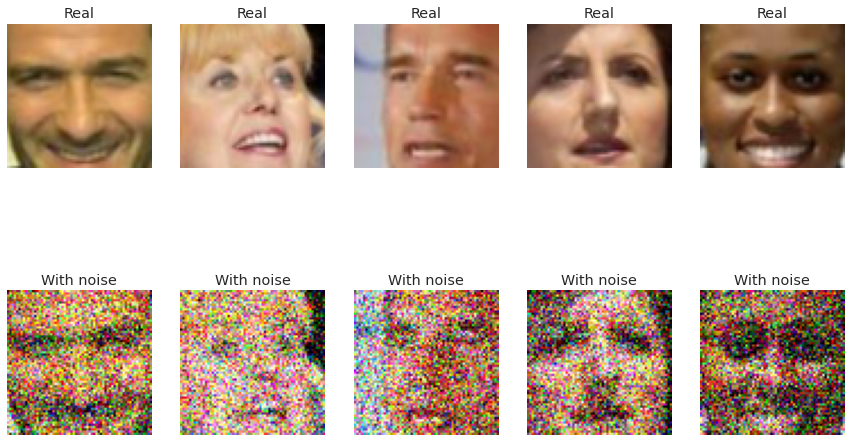

In [ ]:
x_val, y_val = next(iter(val_loader))
x_val = np.clip(x_val.numpy(), 0, 1)
y_val = np.clip(y_val.numpy(), 0, 1)


plt.figure(figsize=(15, 9))
for k in range(5):
    plt.subplot(2, 5, k + 1)
    plt.axis("off")
    plt.imshow(np.rollaxis(y_val[k + 6], 0, 3))
    plt.title('Real')

    plt.subplot(2, 5, k + 6)
    plt.axis("off")
    plt.imshow(np.rollaxis(x_val[k + 6], 0, 3))
    plt.title('With noise')

plt.show();

In [ ]:
dim_code = 256

class AEDenoise(nn.Module):
    def __init__(self):
      # <определите архитектуры encoder и decoder>
      super().__init__()

      self.encoder = nn.Sequential(
          # 1
          nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, padding_mode='replicate'),
          nn.ReLU(),
          # 2
          nn.Conv2d(in_channels=16, out_channels=64, kernel_size=5, stride=2, dilation=2, padding=2, padding_mode='replicate'), # 64 -> 30
          nn.ReLU(),
          # 3
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='replicate'),
          nn.ReLU(),
          # 4
          nn.MaxPool2d(kernel_size=3, stride=2, padding=1), # 30 -> 15
          # 5
          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=2, dilation=2), # 15 -> 4
          nn.ReLU(),

          nn.Flatten(),

          nn.Linear(in_features=4*4*256, out_features=4*256),
          nn.ReLU(),

          nn.Linear(in_features=4*256, out_features=dim_code)
      )

      self.decoder = nn.Sequential(
          nn.Linear(in_features=dim_code, out_features=4*256),
          nn.ReLU(),

          nn.Linear(in_features=4*256, out_features=4*4*256),
          nn.ReLU(),

          nn.Unflatten(1, torch.Size([256, 4, 4])),
          # 6
          nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=5, stride=2, dilation=2), # 4 -> 15
          nn.ReLU(),
          # 7
          nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True), # 15 -> 30
          # 8
          nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          # 9
          nn.ConvTranspose2d(in_channels=64, out_channels=16, kernel_size=5, stride=2, output_padding=1), # 30 -> 64
          nn.ReLU(),
          # 10
          nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=1, padding=1),
          nn.Sigmoid()
      )


    def forward(self, x):
      # <реализуйте forward проход автоэнкодера
      # в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code)
      # и полученная реконструкция изображения (reconstruction)>

      latent_code = self.encoder(x)
      reconstruction = self.decoder(latent_code)

      return reconstruction

In [ ]:
from torchsummary import summary
aeden = AEDenoise().to(DEVICE)
summary(aeden, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
              ReLU-2           [-1, 16, 64, 64]               0
            Conv2d-3           [-1, 64, 30, 30]          25,664
              ReLU-4           [-1, 64, 30, 30]               0
            Conv2d-5          [-1, 128, 30, 30]          73,856
              ReLU-6          [-1, 128, 30, 30]               0
         MaxPool2d-7          [-1, 128, 15, 15]               0
            Conv2d-8            [-1, 256, 4, 4]         819,456
              ReLU-9            [-1, 256, 4, 4]               0
          Flatten-10                 [-1, 4096]               0
           Linear-11                 [-1, 1024]       4,195,328
             ReLU-12                 [-1, 1024]               0
           Linear-13                  [-1, 256]         262,400
           Linear-14                 [-

In [ ]:
def train_model(train_loader, val_loader, model, model_name, epochs, criterion, optimizer):
    X_val = next(iter(val_loader))

    best_loss = 7777
    since = time()

    # loss per batch
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(epochs)):
        set_seed(0 + epoch)
        # train
        model.train()
        train_losses_per_epoch = []

        for x_batch, y_batch in train_loader:
          reconstruction = model(x_batch.float().to(DEVICE))
          loss = criterion(reconstruction, y_batch.float().to(DEVICE))

          loss.backward()
          optimizer.step()

          train_losses_per_epoch.append(loss.detach().cpu().item())

          optimizer.zero_grad()

        train_losses.append(np.mean(train_losses_per_epoch))
        # test
        model.eval()
        val_losses_per_epoch = []

        with torch.no_grad():
          for x_batch, y_batch in val_loader:
            reconstruction = model(x_batch.float().to(DEVICE))
            loss = criterion(reconstruction, y_batch.float().to(DEVICE))

            val_losses_per_epoch.append(loss.detach().cpu().item())

        val_losses.append(np.mean(val_losses_per_epoch))
        # save best model
        if best_loss > val_losses[-1]:
            best_loss = val_losses[-1]
            best_t_loss = train_losses[-1]
            torch.save(model.state_dict(), os.path.join(DATA_DIR, 'best_' + model_name + '.pth'))
            best_epoch = epoch + 1
            best_time = time() - since
        # save current model
        torch.save(model.state_dict(), os.path.join(DATA_DIR, 'last_' + model_name + '.pth'))
        # Visualize
        clear_output(wait=True)

        truth = np.clip(y_batch.cpu().numpy(), 0, 1)
        noisy = np.clip(x_batch.cpu().numpy(), 0, 1)
        reconstruct = np.clip(reconstruction.cpu().numpy(), 0, 1)

        plt.figure(figsize=(15, 9))

        for k in range(5):
            plt.subplot(6, 5, k + 1)
            plt.imshow(np.rollaxis(truth[k], 0, 3))
            plt.axis("off")
            plt.title('Input')

            plt.subplot(6, 5, k + 6)
            plt.imshow(np.rollaxis(noisy[k], 0, 3))
            plt.axis("off")
            plt.title('Noisy')

            plt.subplot(6, 5, k + 11)
            plt.imshow(np.rollaxis(reconstruct[k], 0, 3))
            plt.axis("off")
            plt.title('Output')

        plt.subplot(2,1,2)
        plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label="train loss")
        plt.plot(np.arange(1, len(val_losses) + 1), val_losses, label="val loss")
        best_ep = np.argmin(val_losses) + 1
        plt.axvline(best_ep, color='r', label="best epoch")
        plt.legend(loc='upper right')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.title(model_name + " loss")

        plt.suptitle(f'{epoch + 1} / {epochs} - train loss: {train_losses[-1]:.4f} - val loss: {val_losses[-1]:.4f}',
                     fontsize=18)

        plt.show();

    print(f'\nYEAH! Best time {best_time}, best epoch {best_epoch}, best val loss {best_loss}, best train loss {best_t_loss}')
    # load best weights
    model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_' + model_name + '.pth')))

    return model

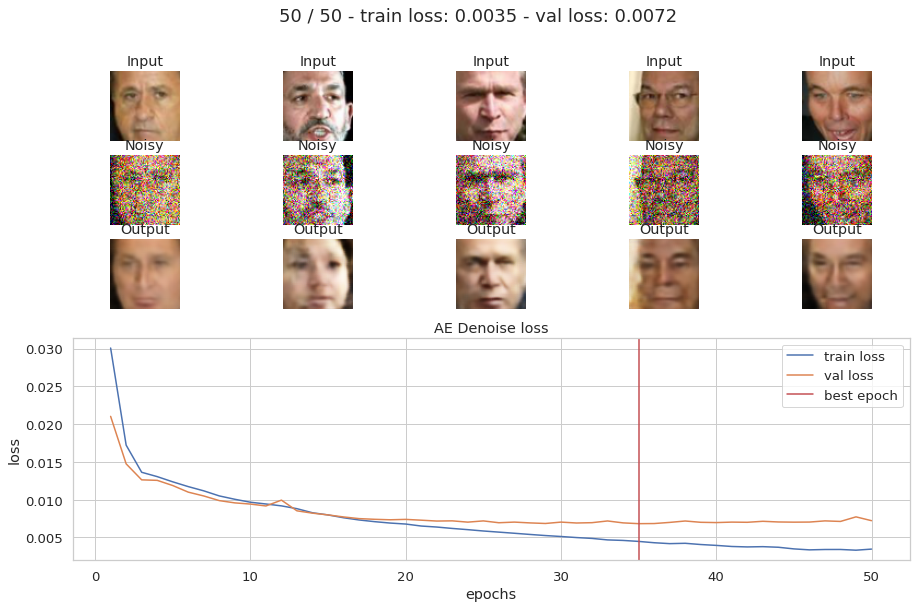


YEAH! Best time 1173.7806279659271, best epoch 35, best val loss 0.006822361203376204, best train loss 0.00447362226005348


In [ ]:
torch.cuda.empty_cache()
aeden = AEDenoise().to(DEVICE)
criterion = F.mse_loss  # args(input, target)
optimizer = optim.AdamW(params = aeden.parameters())
model_name = 'AE Denoise'
epochs = 50
aeden = train_model(train_loader, val_loader, aeden, model_name, epochs, criterion, optimizer)

In [ ]:
aeden = AEDenoise().to(DEVICE)
aeden.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_AE Denoise.pth')))

<All keys matched successfully>

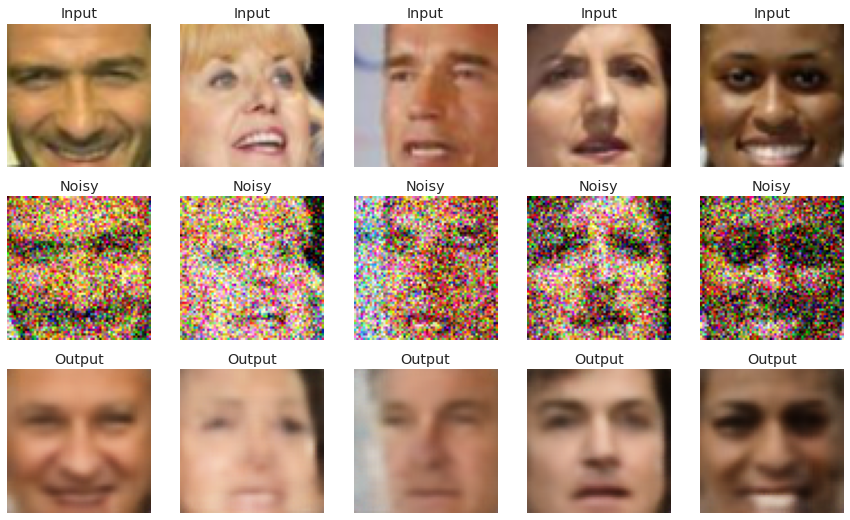

In [ ]:
x_val, y_val = next(iter(val_loader))
y_val = np.clip(y_val.numpy(), 0, 1)

with torch.no_grad():
    x_reconstr = aeden(x_val.float().to(DEVICE)).cpu().numpy()
x_reconstr = np.clip(x_reconstr, 0, 1)
x_val = np.clip(x_val.numpy(), 0, 1)

plt.figure(figsize=(15, 9))
for k in range(5):
    plt.subplot(3, 5, k + 1)
    plt.imshow(np.rollaxis(y_val[k + 6], 0, 3))
    plt.axis("off")
    plt.title('Input')

    plt.subplot(3, 5, k + 6)
    plt.imshow(np.rollaxis(x_val[k + 6], 0, 3))
    plt.axis("off")
    plt.title('Noisy')

    plt.subplot(3, 5, k + 11)
    plt.imshow(np.rollaxis(x_reconstr[k + 6], 0, 3))
    plt.axis("off")
    plt.title('Output')

plt.show();

Автоэнкодер хорошо удаляет шум на фото, однако с восстановлением лиц и мимики у него определенные проблемы, что неудивительно, учитывая урезанность выборки. Обучается модель довольно быстро и уже с 17-й эпохи начинается переобучение. Качество изображения можно повысить, увеличив количество сверточных слоев и/или увеличив размер латентного вектора.

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Обучим новый VAE, т.к. предыдущий учился на других параметрах.

In [ ]:
data, attrs = fetch_dataset()

X_train, X_val, atts_train, attrs_val = train_test_split(data, attrs, train_size=0.8,
                                                        shuffle=True, random_state=1
                                                        )

In [ ]:
train_loader = DataLoader(np.rollaxis(X_train, 3, 1), batch_size=256,
                          shuffle=True, drop_last=True
                          )
val_loader = DataLoader(np.rollaxis(X_val, 3, 1), batch_size=256,
                          shuffle=False, drop_last=True
                        )

Напишем архитектуру:

In [ ]:
features = 256

class VAE_fetch(nn.Module):
    def __init__(self):
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста",
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super().__init__()

        self.encoder = nn.Sequential(
            # s1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding = 1, padding_mode='replicate'),
            nn.ReLU(),
            # 2
            nn.MaxPool2d(kernel_size=2), # 64 -> 32
            # 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1), # 32 -> 16
            nn.ReLU(),

            nn.Flatten(),

            nn.Linear(in_features=16*16*64, out_features=16*64),
            nn.ReLU(),

            nn.Linear(in_features=16*64, out_features=features*2)
          )

        self.decoder = nn.Sequential(

            nn.Linear(in_features=features, out_features=16*64),
            nn.ReLU(),

            nn.Linear(in_features=16*64, out_features=16*16*64),
            nn.ReLU(),

            nn.Unflatten(1, torch.Size([64, 16, 16])),
            # 4
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1), # 16 -> 32
            nn.ReLU(),
            # 5
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1), # 32 -> 64
            nn.ReLU(),
            # 6
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=1)
        )


    def encode(self, x):
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]

        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:

            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            sample = mu + (eps * std)

        else:
            sample = mu

        return sample

    def decode(self, z, eps=1e-7):
        x = self.decoder(z)
        reconstruction = torch.clamp(x.sigmoid(), min=eps, max=1-eps)

        return reconstruction

    def sample(self, z, eps=1e-7):
        generated = self.decoder(z)
        generated = torch.clamp(torch.sigmoid(generated), 0+eps, 1-eps)
        return generated

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

In [ ]:
import torchsummary
vaef = VAE_fetch().to(DEVICE)
torchsummary.summary(vaef, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
         MaxPool2d-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 16, 16]          32,832
              ReLU-5           [-1, 64, 16, 16]               0
           Flatten-6                [-1, 16384]               0
            Linear-7                 [-1, 1024]      16,778,240
              ReLU-8                 [-1, 1024]               0
            Linear-9                  [-1, 512]         524,800
           Linear-10                 [-1, 1024]         263,168
             ReLU-11                 [-1, 1024]               0
           Linear-12                [-1, 16384]      16,793,600
             ReLU-13                [-1, 16384]               0
        Unflatten-14           [-1, 64,

Зададим функцию потерь:

In [ ]:
def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss / mu.shape[0]

def log_likelihood(x, reconstruction):
    batch = x.shape[0]
    x = x.view(-1)
    reconstruction = reconstruction.view(-1)
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x) / batch

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

Функция обучения:

In [ ]:
def train_model(train_loader, val_loader, model, model_name, epochs, criterion,
                optimizer, scheduler):

    best_loss = 77777
    since = time()

    # loss per batch
    train_losses = []
    test_losses = []

    for epoch in tqdm(range(epochs)):
        set_seed(0 + epoch)
        # train
        model.train()
        train_losses_per_epoch = []

        for x_batch in train_loader:
          x_batch = x_batch.to(DEVICE)
          mu, logsigma, reconstruction = model(x_batch)
          loss = criterion(x_batch, mu, logsigma, reconstruction)

          loss.backward()
          optimizer.step()

          train_losses_per_epoch.append(loss.detach().cpu().item())

          optimizer.zero_grad()

        train_losses.append(np.mean(train_losses_per_epoch))

        scheduler.step()
        # test
        model.eval()
        test_losses_per_epoch = []

        with torch.no_grad():
          for x_batch in val_loader:
            x_batch = x_batch.to(DEVICE)
            mu, logsigma, reconstruction = model(x_batch)
            loss = criterion(x_batch, mu, logsigma, reconstruction)

            test_losses_per_epoch.append(loss.detach().cpu().item())

        test_losses.append(np.mean(test_losses_per_epoch))
        # save best model
        if best_loss > test_losses[-1]:
            best_loss = test_losses[-1].round(2)
            best_t_loss = train_losses[-1].round(2)
            torch.save(model.state_dict(), os.path.join(DATA_DIR, 'best_' + model_name + '.pth'))
            best_epoch = epoch + 1
            best_time = round(time() - since)
        # save current model
        torch.save(model.state_dict(), os.path.join(DATA_DIR, 'last_' + model_name + '.pth'))
        # Visualize
        clear_output(wait=True)

        truth = x_batch.cpu().numpy()
        reconst = reconstruction.cpu().numpy()

        plt.figure(figsize=(15, 9))

        for k in range(5):
            plt.subplot(4, 5, k + 1)
            plt.imshow(np.rollaxis(truth[k], 0, 3))
            plt.axis("off")
            plt.title('Input')

            plt.subplot(4, 5, k + 6)
            plt.imshow(np.rollaxis(reconst[k], 0, 3))
            plt.axis("off")
            plt.title('Output')

        plt.subplot(2,1,2)
        plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label="train loss")
        plt.plot(np.arange(1, len(test_losses) + 1), test_losses, label="val loss")
        best_ep = np.argmin(test_losses) + 1
        plt.axvline(best_ep, color='r', label="best epoch")
        plt.legend(loc='upper right')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.title(model_name + " loss")

        plt.suptitle(f'{epoch + 1} / {epochs} - train loss: {train_losses[-1]:.4f} - val loss: {test_losses[-1]:.4f}',
                     fontsize=18)

        plt.show();

    print(f'\nYEAH! Best time {best_time}, best epoch {best_epoch}, best val loss {best_loss}, best train loss {best_t_loss}')
    # load best weights
    model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_' + model_name + '.pth')))

    return model

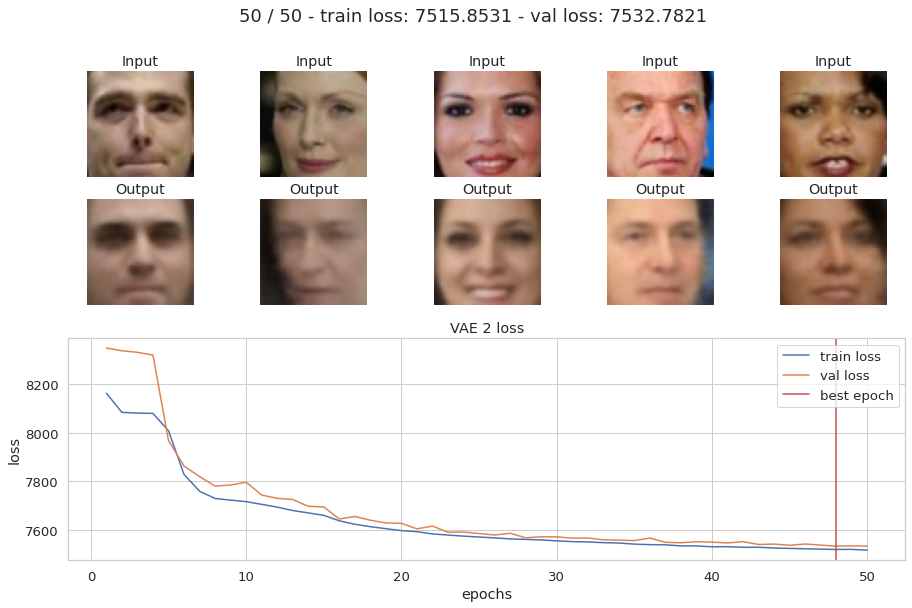


YEAH! Best time 282, best epoch 48, best val loss 7532.43, best train loss 7518.8


In [ ]:
torch.cuda.empty_cache()
criterion = loss_vae
vaef = VAE_fetch().to(DEVICE)
optimizer =  optim.AdamW(params = vaef.parameters())
model_name = 'VAE 2'
epochs = 50
scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
vaef = train_model(train_loader, val_loader, vaef, model_name, epochs, criterion, optimizer, scheduler)

Загрузим модель:

In [ ]:
vaef = VAE_fetch().to(DEVICE)
vaef.load_state_dict(torch.load(os.path.join(DATA_DIR, 'best_VAE 2.pth')))

<All keys matched successfully>

Будем применять класс NearestNeighbors, т.к. LSHForest не поддерживается.

Создадим новый даталоадер без перемешивания и с сохранением последнего некомплектного батча, чтобы потом найти по индексам "ближайших соседей".

In [ ]:
t_loader = DataLoader(np.rollaxis(X_train, 3, 1), batch_size=512,
                          shuffle=False, drop_last=False)

# Получим латентные представления всех лиц тренировочного датасета

codes = np.zeros((1,features))

with torch.no_grad():
  vaef.eval()
  for inputs in train_loader:
    inputs = inputs.to(DEVICE)
    latent, _ = vaef.encode(inputs)
    codes = np.concatenate((codes, latent.cpu().numpy()))

codes = np.delete(codes, 0, axis=0)

print(f'Размеры полученных латентных векторов {codes.shape}.')

# Сохраним codes
with open(os.path.join(DATA_DIR, 'codes_latent.pickle'), 'wb') as f:
    pickle.dump(codes, f)

Размеры полученных латентных векторов (10496, 256).


In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5, radius=1, leaf_size=5).fit(codes)

with open(os.path.join(DATA_DIR, 'neighbors_vaef2.pickle'), 'wb') as f:
    pickle.dump(neigh, f)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  t_image = torch.FloatTensor(np.rollaxis(image[np.newaxis], 3, 1)).to(DEVICE)
  vaef.eval()
  with torch.no_grad():
    code, _ = vaef.encode(t_image)

  (distances,),(idx,) = neigh.kneighbors(code.cpu().numpy(), n_neighbors=n_neighbors)

  t_codes = torch.cuda.FloatTensor(codes[idx])

  vaef.eval()
  with torch.no_grad():
    reconst = vaef.decode(t_codes)

  return distances, reconst.cpu().numpy()

In [ ]:
def show_similar(image, n_neighbors=5):
  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances, neighbors = get_similar(image,n_neighbors=n_neighbors)

    plt.figure(figsize=[15,9])
    plt.subplot(2, 5, 1)
    plt.axis("off")
    plt.imshow(image)
    plt.title("Original image")

    for k in range(n_neighbors):
        plt.subplot(2, np.ceil(n_neighbors/2), k + 2)
        plt.axis("off")
        plt.imshow(neighbors[k].transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[k])

    plt.show()

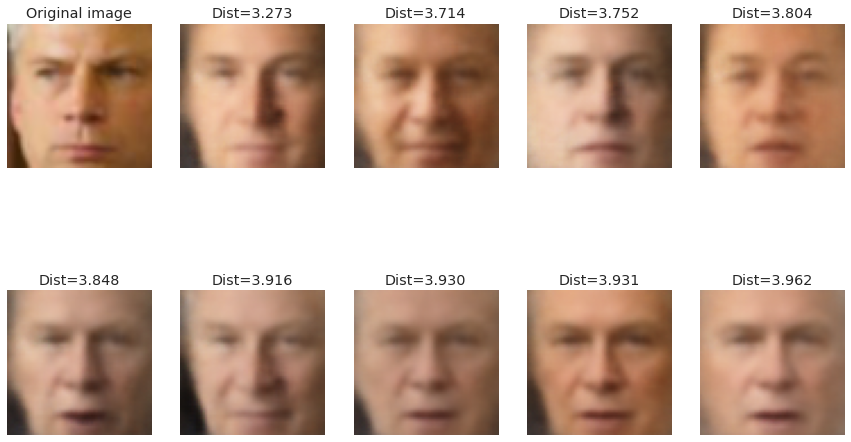

In [ ]:
show_similar(X_val[1], n_neighbors=9)